http://jeroenjanssens.com/2013/09/19/seven-command-line-tools-for-data-science.html

In [1543]:
import numpy as np
from os import path

data_dir = "/home/daniel/git/Python2.7/DataScience/nlp_training_data"

chap_line_nums = np.loadtxt(path.join(data_dir, 'alice_chap_nums.txt'), dtype='int', delimiter='\n')

f = open(path.join(data_dir,'alice.txt'), 'r')
lines = f.readlines()
f.close()
     
print chap_line_nums

[ 212  422  632  891 1160 1461 1792 2137 2454 2778 3077 3343 3637]


In [1544]:
for i in range(chap_line_nums.size - 1):
    chap_num = i + 1
    f = open(path.join(data_dir,'chap_%02i.txt' %chap_num), 'w')
    
    start = chap_line_nums[i]
    end = chap_line_nums[i+1] - 1

    for line in lines[start:end]:
        f.write(line) 
    
    f.close()
    

In [1545]:
import glob

chps = glob.glob(path.join(data_dir,"chap_*.txt"))
chps.sort()

for ch in chps:
    print ch
    

/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_01.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_02.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_03.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_04.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_05.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_06.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_07.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_08.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_09.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_10.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_11.txt
/home/daniel/git/Python2.7/DataScience/nlp_training_data/chap_12.txt


In [1546]:
from nltk import tokenize, stem
import nltk
import re

In [1547]:
def get_chap_sents(filename):
    f = open(filename, 'r')
    lines = f.read()
    f.close()

    sents = tokenize.sent_tokenize(lines)
    sents = map(lambda s:s.replace('\r\n',' '), sents)
    sents = map(lambda s:s.replace('_',''), sents)
    sents = map(lambda s:s.replace(',',' '), sents)
    
    return sents

def join_n_sentences(sentences, n=6):
    new_lines = []
    num_sent = len(sentences)
    index = np.arange(0, num_sent, n)
    
    for i in index:
        concat_lines = ' '.join(sentences[i:i+n+1])
        new_lines.append(concat_lines)
        
    return new_lines    

def build_docs(filename):
    sents = get_chap_sents(filename)
    doc = join_n_sentences(sents)
    
    return doc

def get_nltk_pos(string):
    test = string.decode('ascii', 'ignore')
    test = tokenize.word_tokenize(test)
    pos = nltk.pos_tag(test)
    
    return pos

#pat = "^[NVJR]"
pat = "^[NV]"
reg = re.compile(pat)
def filter_pos(pos):
    out = []
    for item in pos:
        if reg.match(item[1]):
            out.append(item[0])
            
    return out        

def get_pos(doc):
    out = []
    for string in doc:
        pos = get_nltk_pos(string)
        #print pos
        temp = filter_pos(pos)
        string = ' '.join(temp)
        out.append(string)
    
    #out = [item for sub_list in out for item in sub_list]
    return out

def remove_short_words(pos, num_letters=2):
    out = []
    for word in pos.split(' '):
        if len(word) < num_letters:
            continue
        else:
            out.append(word)
         
    return ' '.join(out)    

stem_obj = stem.SnowballStemmer('english')
def stemmer(doc):
    doc = doc.decode('ascii', 'ignore')
    words = tokenize.word_tokenize(doc)
    stems = map(stem_obj.stem, words)
    new_doc = " ".join(stems)
    
    return new_doc

In [1548]:
docs = build_docs(chps[0])
print docs[3] 
print '\n' + str(len(docs)) + " sentences in the doc" + '\nAfter pre-processing:\n'
docs = map(remove_short_words, docs)
docs = map(stemmer, docs)
print docs[3]

Would the fall never come to an end? "I wonder how many miles I've fallen by this time?" she said aloud. "I must be getting somewhere near the centre of the earth. Let me see: that would be four thousand miles down. I think--" (for  you see  Alice had learnt several things of this sort in her lessons in the schoolroom  and though this was not a very good opportunity for showing off her knowledge  as there was no one to listen to her  still it was good practice to say it over) "--yes  that's about the right distance--but then I wonder what Latitude or Longitude I've got to?" (Alice had no idea what Latitude was  or Longitude either  but thought they were nice grand words to say.)

15 sentences in the doc
After pre-processing:

would the fall never come to an end ? `` i wonder how mani mile i ve fallen by this time ? '' she said aloud . `` i must be get somewher near the centr of the earth . let me see : that would be four thousand mile down . think -- '' ( for you see alic had learnt se

## Part of speech tagging

In [1549]:
pos = get_pos(docs)
print pos[0]

[ sidenot rabbit-hol was get veri tire sit sister bank have noth do onc twice had book was read had pictur convers is use book thought pictur convers was mind day made feel veri sleepi ) pleasur make be troubl get pick daisi rabbit pink eye ran was veri remark did think veri way hear rabbit say oh dear oh dear be thought afterward occur have wonder time seem quit natur rabbit took watch look hurri start feet flash mind had seen rabbit watch take burn curios ran field was time see pop larg rabbit-hol hedg moment went onc world was get


In [1550]:
import pandas as pd
df = pd.DataFrame()

#df['doc'] = pos
df['doc'] = docs
df['chap'] = np.ones(len(pos))
df

,doc,chap
0,[ sidenot : down the rabbit-hol ] alic was beg...,1
1,in anoth moment down went alic after it never ...,1
2,thought alic to herself . `` after such fall a...,1
3,would the fall never come to an end ? `` i won...,1
4,( alic had no idea what latitud was or longitu...,1
5,( and she tri to curtsey as she spoke -- fanci...,1
6,`` dinah ll miss me veri much to-night should ...,1
7,and here alic began to get rather sleepi and w...,1
8,thump ! down she came upon heap of stick and d...,1
9,sudden she came upon littl three-leg tabl all ...,1


## Reduce the number of chapters: The full 12 didn't seem to work so well

In [1551]:
#chps = chps[1::2]
print len(chps)

12


In [1552]:
for ind, _file in enumerate(chps[1:], start=2):
    docs = build_docs(_file)
    docs = map(remove_short_words, docs)
    docs = map(stemmer, docs)
    #docs = get_pos(docs)
    n = len(docs)
    temp = pd.DataFrame({ 'doc':docs, 'chap':np.ones(n)*ind })
    #print temp
    df = pd.concat([df, temp], axis=0)

df.head()

,chap,doc
0,1,[ sidenot : down the rabbit-hol ] alic was beg...
1,1,in anoth moment down went alic after it never ...
2,1,thought alic to herself . `` after such fall a...
3,1,would the fall never come to an end ? `` i won...
4,1,( alic had no idea what latitud was or longitu...


In [1553]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer

In [1554]:
grp = df.groupby('chap')
cnts = grp.chap.count()
_sum = grp.chap.count().sum()
mu = grp.chap.count().mean()

print cnts, "\n total", _sum, "\n mean", mu

chap
1       15
2       20
3       20
4       25
5       23
6       25
7       30
8       24
9       28
10      26
11      21
12      20
Name: chap, dtype: int64 
 total 277 
 mean 23.0833333333


In [1555]:
stop_words = ENGLISH_STOP_WORDS.union(['alice', 'chapter', 'illustration'])

In [1556]:
min_df = cnts.min() - 3
max_df = np.floor(cnts.mean() * 3)

vectorizer = TfidfVectorizer(max_features=150,
                             lowercase=True,
                             max_df=max_df,
                             min_df=min_df,
                             use_idf=True,
                             stop_words=stop_words,
                             norm='l2',
                             ngram_range=(1, 3),
                             analyzer='word',
                             decode_error='ignore',
                             strip_accents='unicode'
                            )

In [1557]:
# vectorizer = CountVectorizer(max_features=200,
#                              lowercase=True,
#                              max_df=50,
#                              min_df=10,
#                              stop_words=stop_words,
#                              ngram_range=(1, 13),
#                              analyzer='word',
#                              decode_error='ignore',
#                              strip_accents='unicode'
#                              )

In [1558]:
matrix = vectorizer.fit_transform(df['doc'])
features = vectorizer.get_feature_names()
features.sort()       

print matrix.shape 
print features
# vectorize the "docs"
# kmeans and store cluster in df

(277, 150)
[u'ad', u'alic', u'ani', u'anoth', u'anxious', u'anyth', u'arm', u'ask', u'away', u'befor', u'began', u'begin', u'ca', u'came', u'cat', u'caterpillar', u'certain', u'chang', u'come', u'cours', u'court', u'creatur', u'cri', u'curious', u'day', u'dear', u'did', u'doe', u'door', u'dormous', u'duchess', u'eat', u'end', u'eye', u'face', u'feel', u'feet', u'felt', u'finish', u'garden', u'good', u'got', u'great', u'grow', u'gryphon', u'half', u'hand', u'happen', u'hard', u'hare', u'hatter', u'head', u'hear', u'heard', u'hous', u'howev', u'hurri', u'idea', u'illustr', u'just', u'king', u'know', u'larg', u'left', u'let', u'like', u'littl', u'live', u'll', u'long', u'look', u'make', u'march', u'march hare', u'mean', u'minut', u'mock', u'mock turtl', u'moment', u'mous', u'near', u'noth', u'oh', u'old', u'onc', u'onli', u'open', u'perhap', u'pleas', u'poor', u'queen', u'question', u'quit', u'rabbit', u'remark', u'rememb', u'repeat', u'repli', u'right', u'round', u'said', u'said alic', u

In [1559]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics

In [1560]:
cos_sim = cosine_similarity(matrix)
cos_dist.shape

(277, 277)

## We'd like to see clusters about the diagonal
Bright spots away from the diagonal mean that a "document", or chunk
of sentences, are correlating with a chunk from far away.

<matplotlib.colorbar.Colorbar instance at 0x7f683743f878>

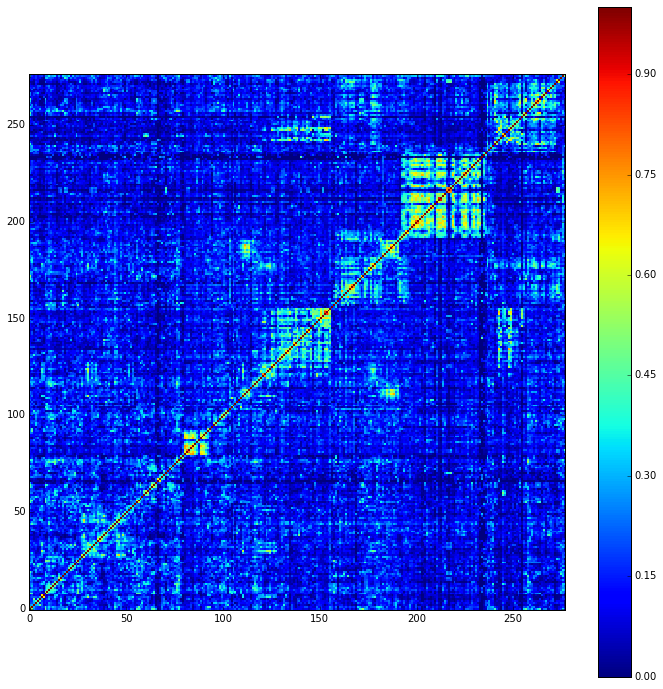

In [1561]:
plt.figure(figsize=(12, 12))
plt.imshow(cos_sim, origin='lower', interpolation='nearest')
plt.colorbar()

In [1562]:
cos_dist = cosine_distances(matrix)
euc_dist = euclidean_distances(matrix)

k = len(chps)
km = KMeans(k,
            #init='random',
            init='k-means++', 
            n_init=10, 
            max_iter=20000, 
            tol=1e-7, 
            precompute_distances='auto', 
            verbose=0, 
            random_state=1, 
            copy_x=True,
            n_jobs=4
            )

assignments = km.fit_predict(euc_dist)
print np.unique(assignments)

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [1563]:
df['cluster_chaps'] = assignments + 1

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score

Homogeneity metric of a cluster labeling given a ground truth
A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

In [1564]:
metrics.homogeneity_score(df.chap, df.cluster_chaps)

0.21615178287902811

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score

Completeness metric of a cluster labeling given a ground truth
A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
This metric is independent of the absolute values of the labels: a permutation of the class or cluster label values won’t change the score value in any way.

In [1565]:
metrics.completeness_score(df.chap, df.cluster_chaps)

0.25394874306716991

chap
1       [[Axes(0.125,0.125;0.775x0.775)]]
2       [[Axes(0.125,0.125;0.775x0.775)]]
3       [[Axes(0.125,0.125;0.775x0.775)]]
4       [[Axes(0.125,0.125;0.775x0.775)]]
5       [[Axes(0.125,0.125;0.775x0.775)]]
6       [[Axes(0.125,0.125;0.775x0.775)]]
7       [[Axes(0.125,0.125;0.775x0.775)]]
8       [[Axes(0.125,0.125;0.775x0.775)]]
9       [[Axes(0.125,0.125;0.775x0.775)]]
10      [[Axes(0.125,0.125;0.775x0.775)]]
11      [[Axes(0.125,0.125;0.775x0.775)]]
12      [[Axes(0.125,0.125;0.775x0.775)]]
dtype: object

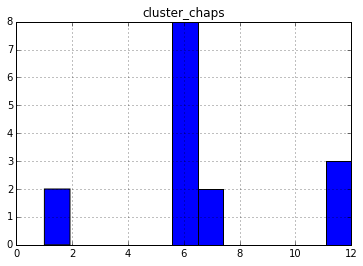

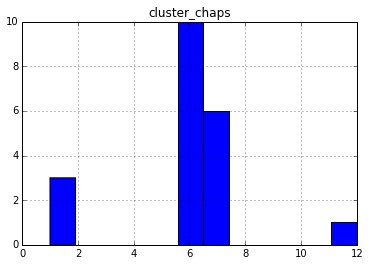

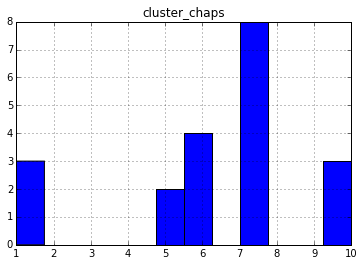

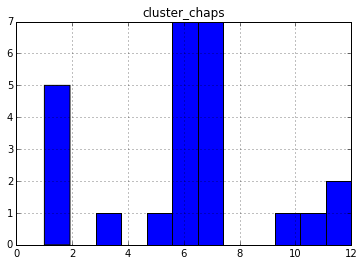

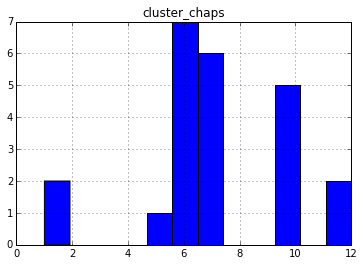

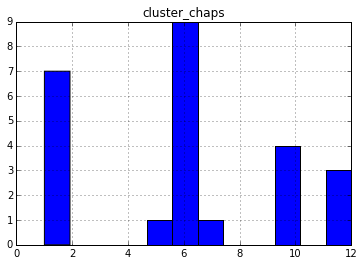

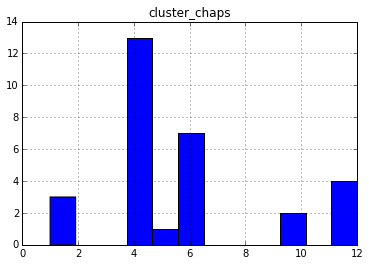

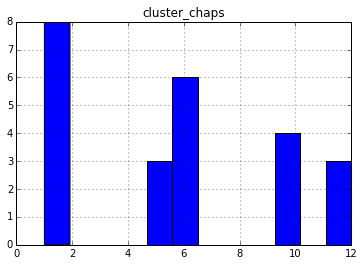

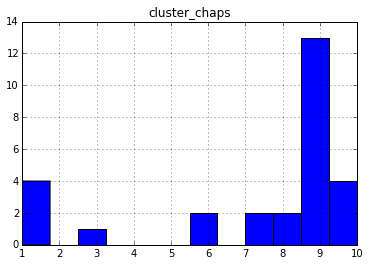

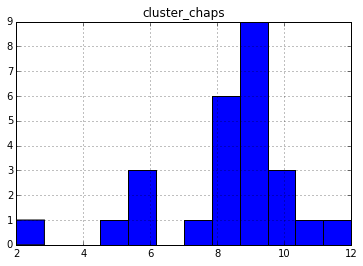

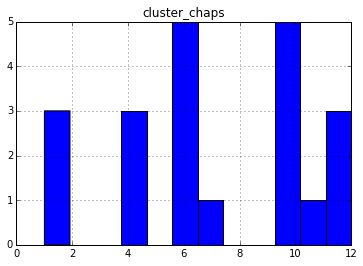

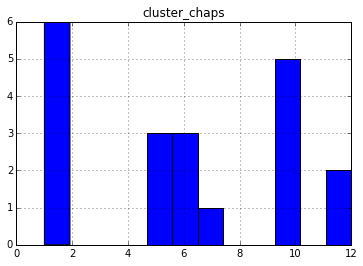

In [1566]:
grp = df.groupby('chap')
grp.hist(bins=k)

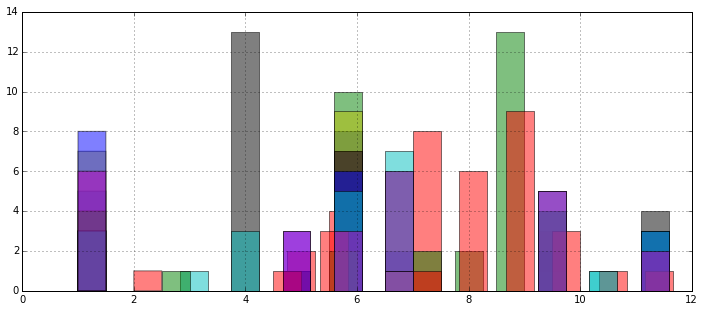

In [1567]:
%matplotlib inline
for i in range(1, k+1):
    df[df.chap == i]['cluster_chaps'].hist(figsize=(12,5), alpha=0.5, width=0.5, bins=k)